# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"><img src="images/icon102.png" width="38px"></img> **Hopsworks Feature Store** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 03: Model training & UI Exploration</span>

<span style="font-width:bold; font-size: 1.4rem;">In this last notebook, we will train a model on the dataset we created in the previous tutorial. We can train our model using standard Python and machine learning frameworks such as Scikit-learn, PySpark, TensorFlow, and PyTorch.</span>

## **🗒️ This notebook is divided in 3 main sections:** 
1. **Loading the training data.**
2. **Train models.**
3. **Model's Predictions Visualization.**

![tutorial-flow](images/03_model.png)

To begin with lets connect to Hopsworks Feature Store

In [1]:
import hsfs

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

First, we'll need to fetch the training dataset that we created in the previous notebook.

To retrieve training dataset from Feature Store we retrieve **Feature View** using `FeatureStore.get_feature_view()` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_train_test_split()` method.

In [2]:
feature_view = fs.get_feature_view(
    name = "train_data",
    version = 1
)

In [3]:
X_train, y_train, X_test, y_test = feature_view.get_train_test_split(
    training_dataset_version = 2
)

In [4]:
X_train.head()

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,previous_loan_counts
0,100016,1,0,1,0,0,67500.0,80865.0,5881.5,67500.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,7
1,100030,1,0,1,0,0,90000.0,225000.0,11074.5,225000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6
2,100032,1,1,1,0,1,112500.0,327024.0,23827.5,270000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,100033,1,1,0,0,0,270000.0,790830.0,57676.5,675000.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,100043,1,0,1,0,2,198000.0,641173.5,23157.0,553500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,2


In [5]:
y_train.head()

,target
0,0
1,0
2,0
3,0
4,0


---

# <span style="color:#ff5f27;"> 🤖 Modeling</span>

#### <span style="color:#ff5f27;">📝 Importing Libraries</span>

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score

---

## <span style="color:#ff5f27;"> 🧑🏻‍🔬 RandomForestClassifier</span>

In [7]:
pos_class_weight = 0.9

In [8]:
model = RandomForestClassifier(
    n_estimators = 25,
    max_features = 'sqrt',
    class_weight = {0: 1.0 - pos_class_weight, 1: pos_class_weight},
    n_jobs = -1,
    random_state = 42
)

model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.09999999999999998, 1: 0.9},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
preds = model.predict(X_test)

accuracy_score(y_test, preds)

0.9213418160786582

---

## <span style="color:#ff5f27;"> 🧑🏻‍🔬 XGBoost</span>

In [10]:
xgb_reg = xgb.XGBClassifier(
    n_estimators = 15,
    random_state = 42
)

xgb_reg.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [11]:
preds = xgb_reg.predict(X_test)

accuracy_score(y_test, preds)

0.9208460712220111

---

## <span style="color:#ff5f27;"> 🔬 🧬 Model Predictions Visualization</span>

In [12]:
import plotly.express as px
import seaborn as sns
%matplotlib inline 

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [14]:
data = X_test.copy()
data['labels'] = preds
data['real'] = y_test

columns = X_train.apply(pd.Series.var).sort_values(ascending = False).index[:3]

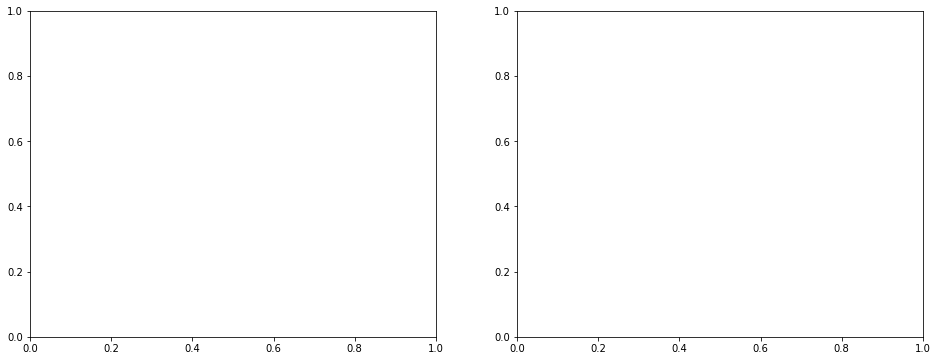

In [15]:
fig,ax = plt.subplots(1,2,figsize = (16,6))

ax[0] = px.scatter_3d(data, x=columns[0], y=columns[1], z=columns[2],
                    color='labels')

ax[1] = px.scatter_3d(data, x=columns[0], y=columns[1], z=columns[2],
                    color='real')

fig.show('notebook')

---